## Computational Cost Experiments of Oversampling Methods

This notebook measures and compares the computational cost (runtime) of various oversampling algorithms (SMOTE, bSMOTE, ROS, ADASYN, MWMOTE, CTGAN, GAMO, MGVAE and our porposed MMD+Triplet oversampler) across varying dataset sizes and feature dimensions.

### 1. Imports and Environment Setup

In [1]:
import sys

sys.path.append("/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs")
sys.path.append('/home/oldrain123/IMBALANCED_CLASSIFICATION/')
sys.path.append('/home/oldrain123/IMBALANCED_CLASSIFICATION/SMOTE_variants/')

In [2]:
import os
import time 
import logging
from dataclasses import dataclass, asdict
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
import torch 
from tqdm.autonotebook import tqdm 
import matplotlib.pyplot as plt 

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler, ADASYN
from SMOTE_variants.sm_variants.oversampling import MWMOTE 

from ctgan import CTGAN 
from moms_generate import transform 
from moms_losses import MMD_est_torch

from gamosampler import GAMOtabularSampler
from mgvae import MGVAE

/tmp/ipykernel_884645/2664166465.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
logging.basicConfig(level=logging.WARNING, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
print(f"Using device: {DEVICE}")

Using device: cuda


### 2. Configuration 

In [4]:
@dataclass
class Config:
    seed: int = 1203
    # for sample-size experiment (dim fixed to 10)
    n_totals: List[int] = (100, 500, 1000, 2000)
    # for dimension experiment (n_total fixed to 1000)
    dims: List[int] = (5, 10, 50, 100, 200)
    min_frac: float = 0.1
    n_runs: int = 10
    ctgan_epochs: int = 1000
    ours_epochs: int = 1000
    gamo_epochs: int = 1000  
    mgvae_pretrain: int = 1000  
    mgvae_finetune: int = 1000  
    fixed_dim: int = 50
    fixed_n: int = 1000

cfg = Config()
logging.info(f"Config: {asdict(cfg)}")

# Seed everything
np.random.seed(cfg.seed)
if DEVICE != "cpu":
    torch.manual_seed(cfg.seed)

### 3. Dataset Generation

In [5]:
def create_dataset(
    dim: int,
    total_size: int,
    minority_frac: float,
    shift: float = 0.3
) -> Tuple[np.ndarray, np.ndarray]:
    n_min = int(total_size * minority_frac)
    n_maj = total_size - n_min
    mu0 = np.zeros(dim); mu1 = np.ones(dim) * shift; cov = np.eye(dim)
    X0 = np.random.multivariate_normal(mu0, cov, size=n_maj)
    X1 = np.random.multivariate_normal(mu1, cov, size=n_min)
    X = np.vstack([X0, X1]); y = np.hstack([np.zeros(n_maj), np.ones(n_min)])
    return X, y

### 4. Runtime Measurement 

In [6]:
def measure_runtime(
    method: str,
    X: np.ndarray,
    y: np.ndarray,
    sampler: Any,
    ctgan_epochs: int,
    ours_epochs: int,
    n_runs: int,
    seed: int
) -> float:
    rng = np.random.RandomState(seed)
    durations = []
    for run in range(n_runs):
        idx = rng.permutation(len(y))
        Xr, yr = X[idx], y[idx]
        t0 = time.perf_counter()
        if method == "CTGAN":
            df_min = pd.DataFrame(Xr[yr == 1])
            df_min.columns = df_min.columns.astype(str)
            ctgan = CTGAN(epochs=ctgan_epochs, cuda=True)
            ctgan.fit(df_min)
            n_gen = int((yr == 0).sum() - (yr == 1).sum())
            ctgan.sample(n=n_gen)
        elif method == "GAMO":
            X_min = Xr[yr == 1]
            X_maj = Xr[yr == 0]
            gamo = GAMOtabularSampler(
                input_dim=X_min.shape[1], 
                latent_dim = max(1, X_min.shape[1]*32),
                hidden_dims = [X_min.shape[1]*2, X_min.shape[1]*4, X_min.shape[1]*8, X_min.shape[1]*16],
                device=DEVICE
            )
            gamo.fit(X_min, X_maj, n_epochs=cfg.gamo_epochs)
            n_gen = (yr == 0).sum() - (yr == 1).sum()
            gamo.sample(n_gen)

        elif method == "MGVAE":
            X_maj = Xr[yr == 0]
            X_min = Xr[yr == 1]
            mgvae = MGVAE(
                input_dim=X_maj.shape[1], 
                latent_dim = max(1, X_min.shape[1]*32),
                hidden_dims = [X_min.shape[1]*2, X_min.shape[1]*4, X_min.shape[1]*8, X_min.shape[1]*16],
                device=DEVICE
            )
            mgvae.pretrain(torch.tensor(X_maj, dtype=torch.float32).to(DEVICE), 
                          epochs=cfg.mgvae_pretrain)
            pretrain_params = {n: p.clone().detach() for n, p in mgvae.named_parameters()}
            fisher = mgvae.compute_fisher(torch.tensor(X_maj, dtype=torch.float32).to(DEVICE))
            mgvae.finetune(
                torch.tensor(X_min, dtype=torch.float32).to(DEVICE),
                torch.tensor(X_maj, dtype=torch.float32).to(DEVICE),
                fisher, pretrain_params, epochs=cfg.mgvae_finetune
            )
            n_gen = len(X_maj) - len(X_min)
            mgvae.sample(torch.tensor(X_maj, dtype=torch.float32).to(DEVICE), n_gen)
        
        elif method == "Ours":
            X_maj = Xr[yr == 0]
            X_min = Xr[yr == 1]
            transform(
                X_maj=X_maj,
                X_min=X_min,
                in_dim=X.shape[1],
                latent_dim = max(1, X_min.shape[1]*32),
                hidden_dims = [X_min.shape[1]*2, X_min.shape[1]*4, X_min.shape[1]*8, X_min.shape[1]*16],
                loss_fn=MMD_est_torch,
                kernel_type="gaussian",
                device=DEVICE,
                method="direct",
                n_epochs=ours_epochs,
                lr=2e-3,
                beta=0.01,
                seed=seed + run,
                residual=True
            )
        else:
            _ = sampler.fit_resample(Xr, yr)
        durations.append(time.perf_counter() - t0)
    return float(np.mean(durations))

### 6. Define Methods

In [7]:
METHODS: Dict[str, Any] = {
    'CTGAN': None,
    'GAMO': None,
    'MGVAE': None,
    'Ours': None,
}

### 7. Run Experiment

In [8]:
from tqdm.autonotebook import tqdm

records_size = []
for n in tqdm(cfg.n_totals, desc="Sample-Size Experiment"):
    X, y = create_dataset(cfg.fixed_dim, n, cfg.min_frac)
    for name, sampler in tqdm(METHODS.items()):
        rt = measure_runtime(
            method=name, X=X, y=y, sampler=sampler,
            ctgan_epochs=cfg.ctgan_epochs, ours_epochs=cfg.ours_epochs,
            n_runs=cfg.n_runs, seed=cfg.seed
        )
        records_size.append({'method':name, 'n_total':n, 'runtime':rt})
df_size = pd.DataFrame(records_size)

Sample-Size Experiment:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/home/oldrain123/anaconda3/envs/imb_clf/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [9]:
records_dim = []
for dim in tqdm(cfg.dims, desc="Dimension Experiment"):
    X, y = create_dataset(dim, cfg.fixed_n, cfg.min_frac)
    for name, sampler in METHODS.items():
        rt = measure_runtime(
            method=name, X=X, y=y, sampler=sampler,
            ctgan_epochs=cfg.ctgan_epochs, ours_epochs=cfg.ours_epochs,
            n_runs=cfg.n_runs, seed=cfg.seed
        )
        records_dim.append({'method':name, 'dim':dim, 'runtime':rt})
df_dim = pd.DataFrame(records_dim)

Dimension Experiment:   0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
df_size

,method,n_total,runtime
0,CTGAN,100,79.066508
1,GAMO,100,58.647423
2,MGVAE,100,37.693003
3,Ours,100,76.210516
4,CTGAN,500,86.675833
5,GAMO,500,55.899052
6,MGVAE,500,76.182067
7,Ours,500,169.618641
8,CTGAN,1000,106.699686
9,GAMO,1000,61.240947


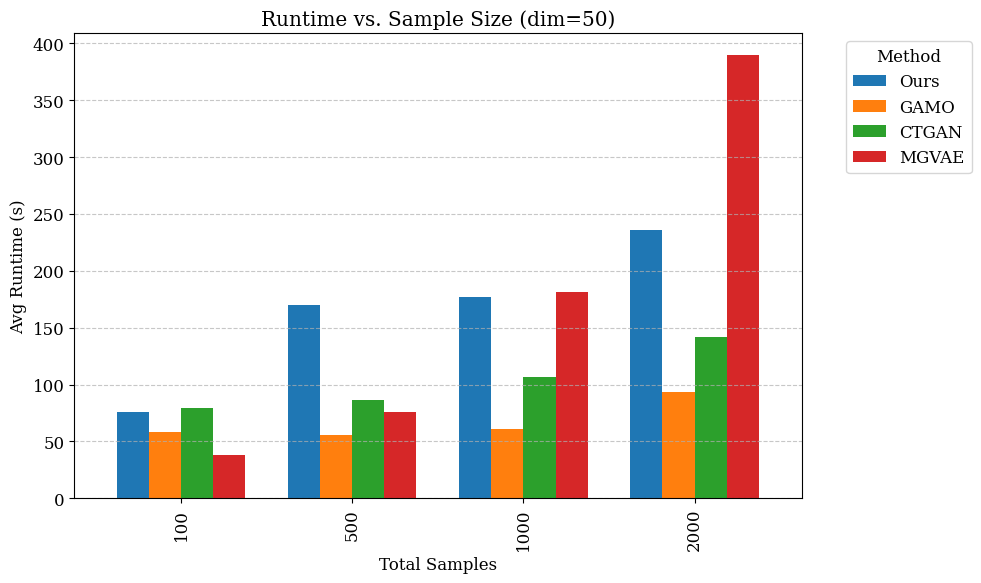

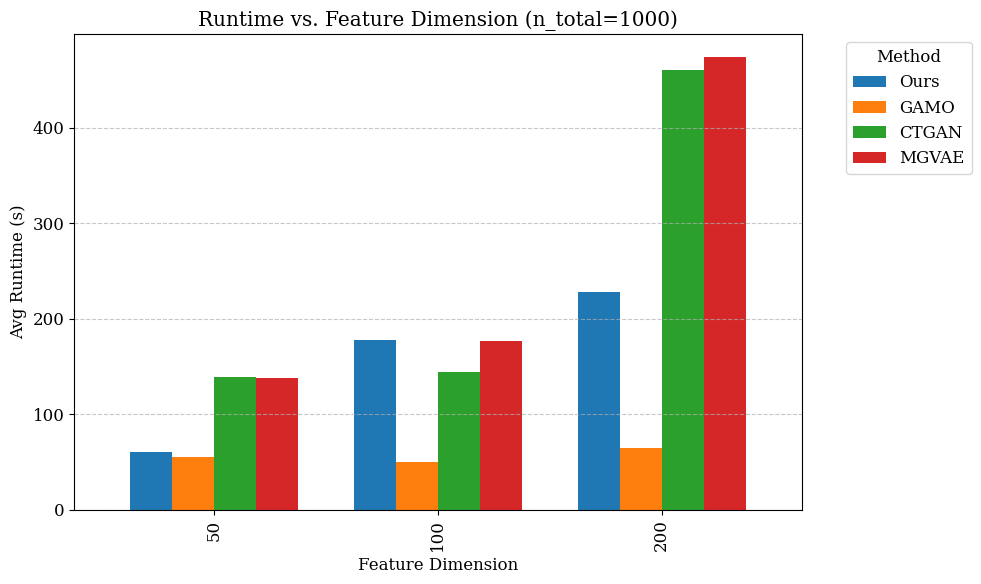

In [10]:
plt.rcParams.update({'font.family':'serif','font.size':12})
methods_order = ['Ours', 'GAMO', 'CTGAN', 'MGVAE']

# 6A. Plot vs Sample Size
fig, ax = plt.subplots(figsize=(10,6))
pivot_s = df_size.pivot(index='n_total', columns='method', values='runtime').reindex(cfg.n_totals)
colors = plt.get_cmap('tab10').colors
pivot_s[methods_order].plot(kind='bar', ax=ax, color=colors, width=0.75, legend=False)
ax.set_xlabel("Total Samples")
ax.set_ylabel("Avg Runtime (s)")
ax.set_title(f"Runtime vs. Sample Size (dim={cfg.fixed_dim})")
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(methods_order, title="Method", bbox_to_anchor=(1.05,1), loc='upper left')
fig.tight_layout()

# **Save both PDF and PNG**
fig.savefig("runtime_vs_samples_fixed_dim.pdf", format='pdf', bbox_inches='tight')
fig.savefig("runtime_vs_samples_fixed_dim.png", dpi=300, bbox_inches='tight')
plt.show()


# 6B. Plot vs Feature Dimension
fig, ax = plt.subplots(figsize=(10,6))
df_dim_tmp = df_dim.loc[df_dim.dim > 0]
pivot_d = df_dim_tmp.pivot(index='dim', columns='method', values='runtime').reindex(cfg.dims[2:])
pivot_d[methods_order].plot(kind='bar', ax=ax, color=colors, width=0.75, legend=False)
ax.set_xlabel("Feature Dimension")
ax.set_ylabel("Avg Runtime (s)")
ax.set_title(f"Runtime vs. Feature Dimension (n_total={cfg.fixed_n})")
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(methods_order, title="Method", bbox_to_anchor=(1.05,1), loc='upper left')
fig.tight_layout()

# **Save both PDF and PNG**
fig.savefig("runtime_vs_dimension_fixed_n.pdf", format='pdf', bbox_inches='tight')
fig.savefig("runtime_vs_dimension_fixed_n.png", dpi=300, bbox_inches='tight')
plt.show()


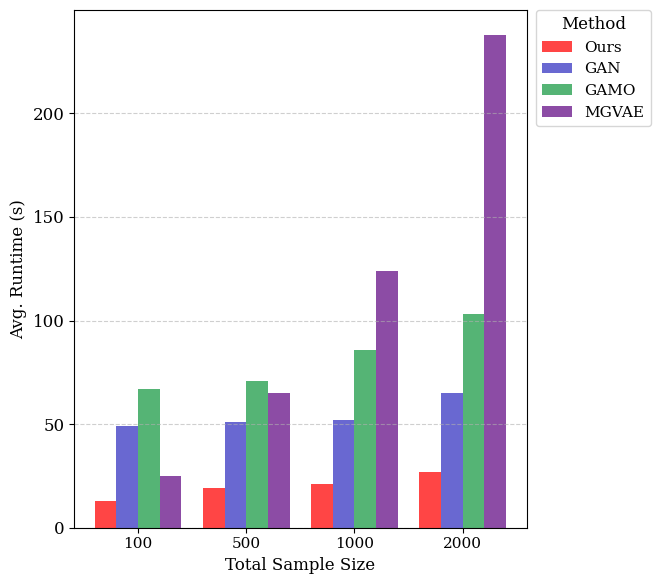

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Data
samples = [100, 500, 1000, 2000]
runtimes = {
    'Ours':  [13,  19,  21,  27],
    'GAN':  [49,  51,  52,  65],
    'GAMO': [67,  71,  86,  103],
    'MGVAE': [25,  65, 124, 238]
}

methods = list(runtimes.keys())
colors = {
    'GAN':   "#6968d1",  # teal
    'GAMO':  "#55B475",  # orange
    'MGVAE': "#8c4ca5",  # purple
    'Ours':  "#ff4545"   # pink
}

# X locations for the groups
x = np.arange(len(samples))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 6))

# Plot each method
for i, method in enumerate(methods):
    ax.bar(
        x + (i - 1.5)*width,
        runtimes[method],
        width,
        label=method,
        color=colors[method]
    )

# Labels and title
ax.set_xlabel('Total Sample Size', fontsize=12)
ax.set_ylabel('Avg. Runtime (s)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(samples, fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Legend outside the plot
ax.legend(
    title='Method',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout(rect=[0, 0, 0.85, 1])

# Save to PDF if desired
# fig.savefig('runtime_vs_samples_dim50.pdf', format='pdf', bbox_inches='tight')

plt.show()


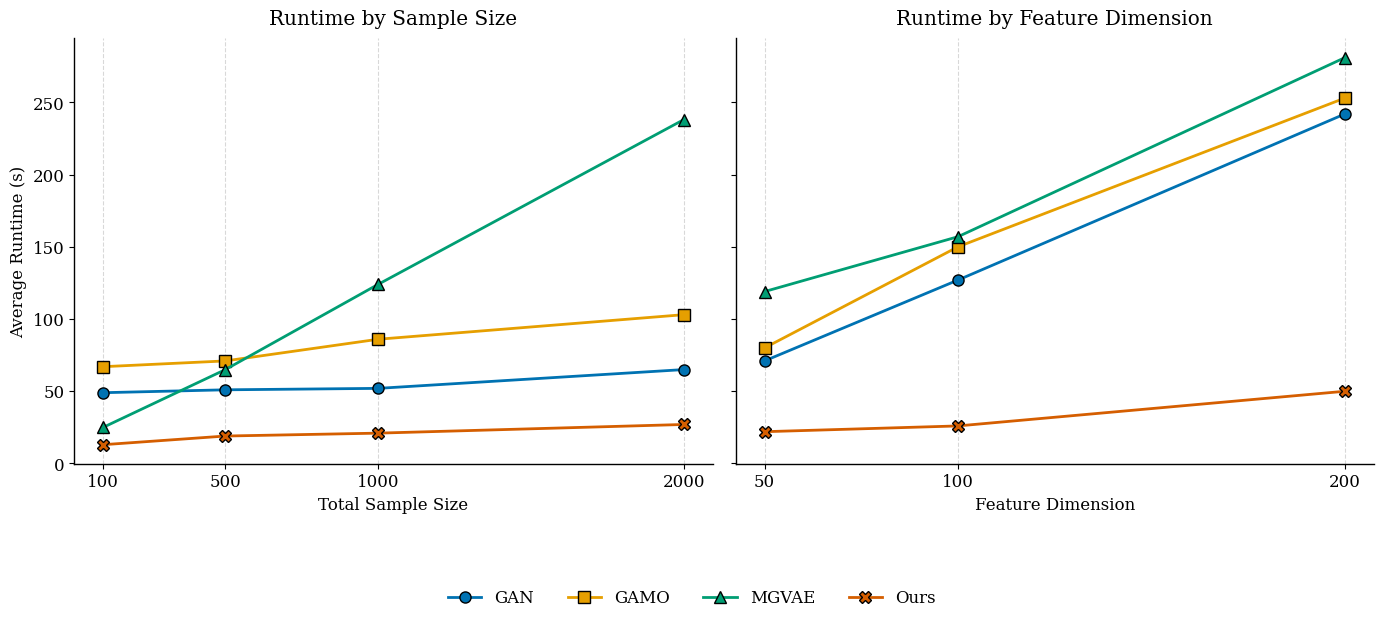

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -----------------------------
# Styling for scientific paper
# -----------------------------
plt.rcParams.update({
    'font.family':    'serif',
    'font.size':       12,
    'axes.linewidth':  1.0,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'grid.linestyle': '--',
    'grid.color':     'gray',
    'grid.alpha':     0.3
})

# -----------------------------
# Data
# -----------------------------
samples      = [100, 500, 1000, 2000]
runtimes_s   = {
    'Ours':  [13,  19,  21,  27],
    'GAN':   [49,  51,  52,  65],
    'GAMO':  [67,  71,  86, 103],
    'MGVAE': [25,  65, 124, 238]
}

feature_dims = [50, 100, 200]
runtimes_d   = {
    'Ours':  [22,  26,  50],
    'GAN':   [71, 127, 242],
    'GAMO':  [80, 150, 253],
    'MGVAE': [119,157, 281]
}

methods = ['GAN', 'GAMO', 'MGVAE', 'Ours']
# Okabe–Ito palette
palette = {
    'GAN':   '#0072B2',
    'GAMO':  '#E69F00',
    'MGVAE': '#009E73',
    'Ours':  '#D55E00'
}
# distinguishable markers
markers = {
    'GAN':   'o',
    'GAMO':  's',
    'MGVAE': '^',
    'Ours':  'X'
}

# -----------------------------
# Plotting
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Subplot 1: runtime vs. total samples
ax = axes[0]
x1 = np.array(samples)
for m in methods:
    ax.plot(
        x1, runtimes_s[m],
        marker=markers[m], markersize=8,
        markeredgecolor='black', markerfacecolor=palette[m],
        linewidth=2, label=m, color=palette[m]
    )
ax.set_title('Runtime by Sample Size', pad=10)
ax.set_xlabel('Total Sample Size')
ax.set_ylabel('Average Runtime (s)')
ax.set_xticks(x1)

# Subplot 2: runtime vs. feature dimension
ax = axes[1]
x2 = np.array(feature_dims)
for m in methods:
    ax.plot(
        x2, runtimes_d[m],
        marker=markers[m], markersize=8,
        markeredgecolor='black', markerfacecolor=palette[m],
        linewidth=2, label=m, color=palette[m]
    )
ax.set_title('Runtime by Feature Dimension', pad=10)
ax.set_xlabel('Feature Dimension')
ax.set_xticks(x2)

# Common styling: remove top/right spines
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y')

# Shared legend at bottom
handles = [
    Line2D([0], [0],
           marker=markers[m], color=palette[m],
           markeredgecolor='black', markersize=8,
           linewidth=2)
    for m in methods
]
fig.legend(
    handles, methods,
    loc='lower center', ncol=len(methods),
    frameon=False, fontsize=12,
    bbox_to_anchor=(0.5, -0.05)
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
fig.savefig('runtime_comparison_lines.pdf', format='pdf', bbox_inches='tight')
plt.show()

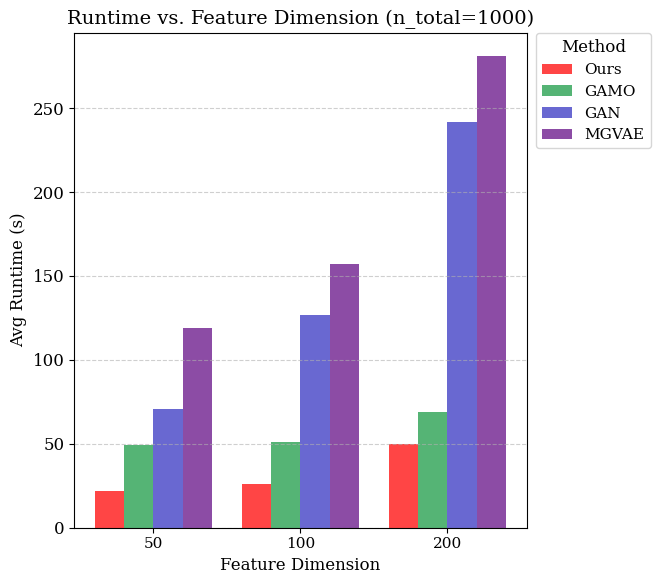

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
feature_dims = [50, 100, 200]
runtimes = {
    'Ours':  [22,  26,  50],
    'GAMO':  [49,  51,  69],
    'GAN': [71, 127, 242],
    'MGVAE': [119,157, 281]
}

methods = list(runtimes.keys())
colors = {
    'GAN':   "#6968d1",  # teal
    'GAMO':  "#55B475",  # orange
    'MGVAE': "#8c4ca5",  # purple
    'Ours':  "#ff4545"   # pink
}

# X locations for the groups
x = np.arange(len(feature_dims))
width = 0.2

fig, ax = plt.subplots(figsize=(8, 6))

# Plot each method
for i, method in enumerate(methods):
    ax.bar(
        x + (i - 1.5) * width,
        runtimes[method],
        width,
        label=method,
        color=colors[method]
    )

# Labels and title
ax.set_xlabel('Runtime by Feature Dimension', fontsize=12)
ax.set_ylabel('Avg Runtime (s)', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(feature_dims, fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Legend outside the plot
ax.legend(
    title='Method',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


In [11]:
def plot_results(df: pd.DataFrame):
    """
    Plot runtime vs. sample size and runtime vs. feature dimension.
    """
    # 1) Runtime vs Sample Size
    fig, ax = plt.subplots(figsize=(16, 12))
    # 각 (n_samples, method)의 runtime 평균 계산 후 wide-form으로 변환
    pivot_samples = (
        df.groupby(['n_samples', 'method'])['runtime']
          .mean()
          .unstack('method')
    )
    pivot_samples.plot(
        kind='bar',
        ax=ax,
        width=0.8
    )
    ax.set_xlabel("Number of Samples")
    ax.set_ylabel("Average Runtime (s)")
    ax.set_title("Oversampling Runtime vs. Sample Size")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    fig.savefig("runtime_vs_samples_bar.png", dpi=300)

    # 2) Runtime vs Feature Dimension
    fig, ax = plt.subplots(figsize=(16, 12))
    pivot_dims = (
        df.groupby(['dim', 'method'])['runtime']
          .mean()
          .unstack('method')
    )
    pivot_dims.plot(
        kind='bar',
        ax=ax,
        width=0.8
    )
    ax.set_xlabel("Feature Dimension")
    ax.set_ylabel("Average Runtime (s)")
    ax.set_title("Oversampling Runtime vs. Feature Dimension")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
    fig.tight_layout()
    fig.savefig("runtime_vs_dimension_bar.png", dpi=300)

    plt.show()

In [12]:
SAMPLE_SIZES = [500, 1000, 5000, 10000]
DIMENSIONS = [50, 100, 1000]
SEED = 1203
METHODS = {
    "SMOTE": SMOTE(random_state=SEED),
    "bSMOTE": BorderlineSMOTE(random_state=SEED),
    "ROS": RandomOverSampler(random_state=SEED),
    "ADASYN": ADASYN(random_state=SEED),
    "MWMOTE": MWMOTE(random_state=SEED),
    "CTGAN": None,
    "Ours": None,
}

# Adjust epochs for CTGAN and our transform for benchmarking
CTGAN_EPOCHS = 1000
TRANSFORM_EPOCHS = 1000
N_RUNS = 10

In [13]:
# Run benchmarks
df_results = benchmark(
    sample_sizes=SAMPLE_SIZES,
    dimensions=DIMENSIONS,
    methods=METHODS,
    ctgan_epochs=CTGAN_EPOCHS,
    transform_epochs=TRANSFORM_EPOCHS,
    n_runs=N_RUNS,
    seed=SEED,
)
df_results.to_csv("benchmark_results.csv", index=False)

NameError: name 'benchmark' is not defined

In [ ]:
plot_results(df_results)

In [ ]:
df_results.groupby(['dim', 'method'])['runtime'].mean().unstack('method')

In [ ]:
df_results.loc[df_results['n_samples'] == 1000]